## Determining an Unknown Players Basketball Position Using K-Nearest Neighbor Classification 

### Marcus Lam (20704185),  Elaina Qiu(94709888), Tegvir Multani (49064660), ___________

### Introduction
In the game of basketball, there are five positions or roles that players play: Point Guard (PG), Shooting Guard (SG), Small Forward (SF), Power Forward (PF), and Center (C)
With our project, we aim to classify a given unknown player into one of these five positions using the K-Nearest Neighbor classification algorithm. 
We are using the official player statistics from the 2022-2023 NBA season as our dataset as it’s the most popular league and updated player stats. 
The dataset contains the names of all the players that played in the 2022-2023 NBA season along with their identifying information (team, age, position), and player statistics (points, rebounds, assists, blocks, steals, turnovers and shooting percentage). 



**Loading Libraries:**

In [11]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

**Downloading and Reading File:**

In [12]:
download.file("https://raw.githubusercontent.com/Elalalaqqq/DSCI-100-2023W2-GROUP-28/main/data/2022-2023%20NBA%20Player%20Stats%20-%20Regular.csv", "data/nbadata.csv")
nbaStats <- read_csv2("data/nbadata.csv")
nbaStats

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 679 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (25): Player, Pos, Tm, FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA, 2P%, eFG%, F...
dbl  (4): Rk, Age, G, GS
num  (1): MP

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,⋯,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Precious Achiuwa,C,23,TOR,55,12,207,3.6,7.3,⋯,0.702,1.8,4.1,6,0.9,0.6,0.5,1.1,1.9,9.2
2,Steven Adams,C,29,MEM,42,42,27,3.7,6.3,⋯,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
3,Bam Adebayo,C,25,MIA,75,75,346,8,14.9,⋯,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
537,Omer Yurtseven,C,24,MIA,9,0,92,1.8,3,⋯,0.833,0.9,1.7,2.6,0.2,0.2,0.2,0.4,1.8,4.4
538,Cody Zeller,C,30,MIA,15,2,145,2.5,3.9,⋯,0.686,1.7,2.6,4.3,0.7,0.2,0.3,0.9,2.2,6.5
539,Ivica Zubac,C,25,LAC,76,76,286,4.3,6.8,⋯,0.697,3.1,6.8,9.9,1,0.4,1.3,1.5,2.9,10.8


**Filter Stats For Minimum 50 Games Played**
- This is to ensure that players with inflated or deflated stats because they play so less won't be taken into account

In [17]:
set.seed(1024)
filteredStats <- nbaStats |>
                    group_by(Player) |>
                    filter(n() == 1 | Tm == "TOT", G >= 50, !(Pos %in% c("PF-SF", "SF-SG", "SG-PG"))) |>
                    ungroup() |>
                    select("Pos", "FTA", "3PA", "TRB":"PTS") |>
                    mutate(Pos = as.factor(Pos)) |>
                    mutate(across(where(is.character), as.numeric))
filteredStats

Pos,FTA,3PA,TRB,AST,STL,BLK,TOV,PF,PTS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C,2.3,2.0,6.0,0.9,0.6,0.5,1.1,1.9,9.2
C,5.4,0.2,9.2,3.2,1.2,0.8,2.5,2.8,20.4
SG,1.2,3.9,2.1,1.1,0.3,0.3,0.7,1.7,7.9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
PF,0.5,0.6,3.1,1.4,1.0,0.1,0.8,1.6,4.4
PG,8.8,6.3,3.0,10.2,1.1,0.1,4.1,1.4,26.2
C,3.1,0.0,9.9,1.0,0.4,1.3,1.5,2.9,10.8


**Get Mean For Each Position:**

In [19]:
positionMean <- filteredStats |>
                group_by(Pos) |>
                summarize(count = n(), across(everything(), mean, na.rm = TRUE))
positionMean

Pos,count,FTA,3PA,TRB,AST,STL,BLK,TOV,PF,PTS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C,53,3.016981,1.488679,7.358491,1.949057,0.6188679,1.0358491,1.409434,2.526415,12.04528
PF,59,2.325424,3.101695,5.040678,1.959322,0.6322034,0.5050847,1.240678,1.972881,10.92373
PG,56,3.041071,4.641071,3.446429,4.973214,1.0214286,0.3196429,1.864286,1.921429,14.16964
SF,53,2.181132,3.901887,3.849057,1.843396,0.7226415,0.3452830,1.120755,1.933962,11.41887
SG,74,2.274324,4.587838,3.245946,2.658108,0.7770270,0.2783784,1.390541,1.831081,12.70405


**Create Mean Statistics Plot For Each Position Using pivot_longer() and facet_wrap()**

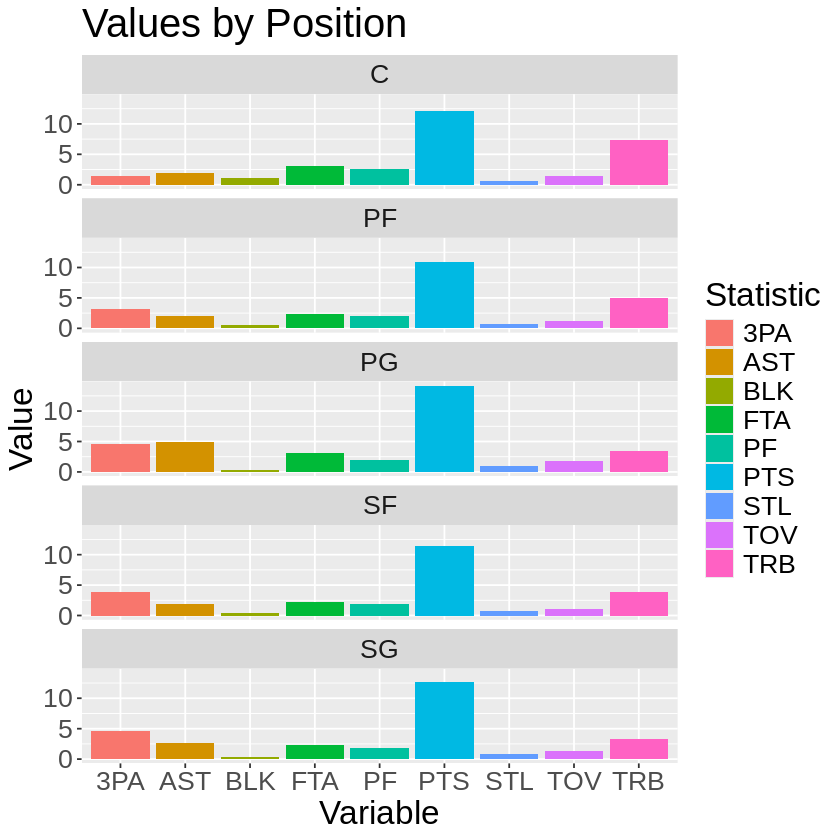

In [20]:
positionMeanLong <- positionMean |>
                    select(-count) |>
                    pivot_longer(cols = -Pos, names_to = "Variable", values_to = "Value")

positionMeanPlot <- positionMeanLong |>
                    ggplot(aes(x = Variable, y = Value, fill = Variable)) +
                    geom_bar(stat = "identity", position = "dodge") +
                    facet_wrap(~Pos, scales = "fixed", ncol = 1) +
                    labs(title = "Values by Position",
                       x = "Variable",
                       y = "Value",
                       fill = "Statistic") +
                    theme(text = element_text(size = 20))

positionMeanPlot

In [29]:
nba_recipe <- recipe(Pos ~ ., data = filteredStats) |> 
    step_scale(all_predictors()) |>
    step_center(all_predictors())

nba_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |> 
	set_engine("kknn") |> 
	set_mode("classification") 

nba_fit <- workflow() |> 
	add_model(nba_spec) |> 
	add_recipe(nba_recipe) |> 
	fit(data = filteredStats) 

NameOfNewObservation <- sample_n(filteredStats, 1)
NameOfNewObservation
predict(nba_fit, NameOfNewObservation) 

Pos,FTA,3PA,TRB,AST,STL,BLK,TOV,PF,PTS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SF,0.8,1,2.3,0.6,0.2,0.2,0.5,1.2,3.9


.pred_class
<fct>
PF
